# 02 – Customer exploration and importance weights

In this notebook we focus on the Northern region and construct an
importance score \(w_i\) for each customer, combining:

- average sales (`VVENTASPROM`),
- installed equipment (`CANTIDADEQ`),
- and total service activity (`Cantidad_total_serv`).

The steps are:

1. Load the synthetic Northern dataset.
2. Inspect the distributions of the three drivers.
3. Apply a trimmed min–max normalisation to each driver.
4. Combine them into a single importance score \(w_i\).
5. Visualise and briefly interpret the resulting weights.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

pd.set_option("display.max_columns", 30)
pd.set_option("display.width", 140)

ROOT_DIR = Path("..")
DATA_DIR = ROOT_DIR / "data"
PATH_NORTH = DATA_DIR / "customers_synthetic_north.csv"

PATH_NORTH

WindowsPath('../data/customers_synthetic_north.csv')

In [2]:
df = pd.read_csv(PATH_NORTH)
df.shape

(63720, 21)

In [3]:
df.head()

,DSREG,CDCLIE,NROPUESUM,VVENTASPROM,LATTUD,LNGTUD,HUB,PESO POR SERVICIOS,CANTIDADEQ,EDADDIAS,Cantserviciosdistri,CantserviciosST,Cantidad total serv,TIEMPO DE EJECUCION PROMEDIO (MINUTOS),TIEMPO PROMEDIO DE LLAMADOS (DIAS),DEPARTAMENTO,DEPARTAMENTO OPTIMO,ZONA OPTIMA,Distancia_punto1_m,Distancia_punto2_m,Cantidad_total_serv
0,NORTE,6.156346e+06,2,23.817759,-8.150649,-79.841065,TRUJILLO,0,1,2522.513428,0,0,1,0.000000,0.379474,LA LIBERTAD,0.975740,NaN,13571,240357,0
1,NORTE,6.050903e+06,1,47.631922,-9.152026,-78.772544,TRUJILLO,1,1,3169.428633,1,0,1,0.000000,0.857509,ANCASH,0.976667,NaN,14264,0,1
2,NORTE,1.866376e+06,2,21.764656,-9.470377,-78.523142,TRUJILLO,0,1,799.794277,1,0,1,1569.841855,0.301505,ANCASH,0.003087,NaN,2964,283391,1
3,NORTE,1.680596e+06,1,37.902756,-9.159700,-80.276835,TRUJILLO,1,1,1299.107842,2,0,1,124.375773,0.000000,CAJAMARCA,0.007660,NaN,113977,444422,2
4,NORTE,7.936723e+06,1,52.424385,-6.774554,-80.288595,TRUJILLO,2,1,2903.683917,2,1,0,0.000000,0.264073,LA LIBERTAD,0.000000,NaN,194098,340663,3


In [4]:
df = df.copy()

# Canonical total-service column
if "Cantidad_total_serv" in df.columns:
    df["Cantidad_total_serv"] = df["Cantidad_total_serv"]
elif "Cantidad total serv" in df.columns:
    df["Cantidad_total_serv"] = df["Cantidad total serv"]
else:
    raise KeyError("No total-service column found in Northern dataset.")

df[["VVENTASPROM", "CANTIDADEQ", "Cantidad_total_serv"]].describe()

,VVENTASPROM,CANTIDADEQ,Cantidad_total_serv
count,63720.000000,63720.000000,63720.000000
mean,59.900891,1.292969,1.118534
std,72.212041,0.607874,1.244002
min,0.000000,1.000000,0.000000
25%,23.061423,1.000000,0.000000
50%,37.556458,1.000000,1.000000
75%,66.187301,1.000000,2.000000
max,507.333952,4.000000,8.000000


In [5]:
def trimmed_minmax(series: pd.Series, trim_q: float = 0.01) -> pd.Series:
    """
    Apply a trimmed min–max normalisation to a numeric series.

    1. Clip the lower/upper trim_q quantiles to reduce the impact of extreme tails.
    2. Rescale the clipped values to the [0, 1] interval.

    If the range collapses (all values equal), the function returns 0.5 everywhere.
    """
    s = series.astype(float)

    q_low = s.quantile(trim_q)
    q_high = s.quantile(1.0 - trim_q)

    s_clipped = s.clip(q_low, q_high)

    s_min = s_clipped.min()
    s_max = s_clipped.max()
    denom = s_max - s_min

    if denom == 0:
        return pd.Series(0.5, index=series.index)

    return (s_clipped - s_min) / denom

In [6]:
df["sales_norm"] = trimmed_minmax(df["VVENTASPROM"])
df["equip_norm"] = trimmed_minmax(df["CANTIDADEQ"])
df["services_norm"] = trimmed_minmax(df["Cantidad_total_serv"])

df[["VVENTASPROM", "sales_norm",
    "CANTIDADEQ", "equip_norm",
    "Cantidad_total_serv", "services_norm"]].head()

,VVENTASPROM,sales_norm,CANTIDADEQ,equip_norm,Cantidad_total_serv,services_norm
0,23.817759,0.036471,1,0.0,0,0.0
1,47.631922,0.086140,1,0.0,1,0.2
2,21.764656,0.032189,1,0.0,1,0.2
3,37.902756,0.065848,1,0.0,2,0.4
4,52.424385,0.096135,1,0.0,3,0.6


In [7]:
df[["sales_norm", "equip_norm", "services_norm"]].describe()

,sales_norm,equip_norm,services_norm
count,63720.000000,63720.000000,63720.000000
mean,0.111595,0.097656,0.222505
std,0.149530,0.202625,0.244257
min,0.000000,0.000000,0.000000
25%,0.034894,0.000000,0.000000
50%,0.065126,0.000000,0.200000
75%,0.124840,0.000000,0.400000
max,1.000000,1.000000,1.000000


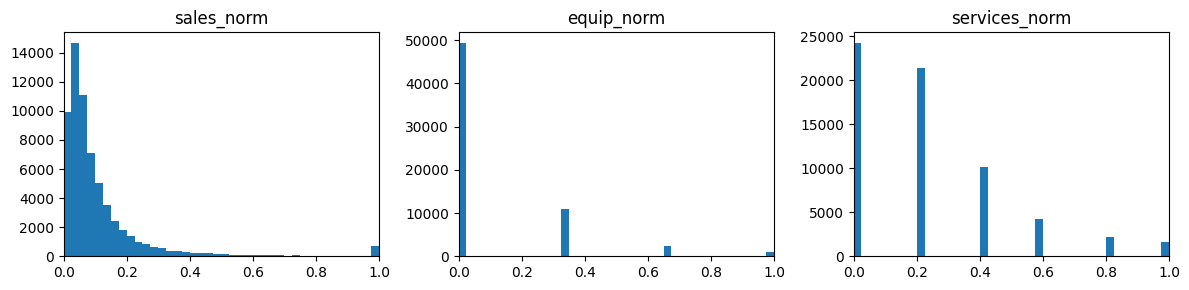

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes = axes.ravel()

for ax, col in zip(axes, ["sales_norm", "equip_norm", "services_norm"]):
    ax.hist(df[col], bins=40)
    ax.set_title(col)
    ax.set_xlim(0, 1)

fig.tight_layout()
plt.show()

In [10]:
alpha_v = 0.4  # sales
alpha_e = 0.3  # equipment
alpha_s = 0.3  # service activity

df["w_importance"] = (
    alpha_v * df["sales_norm"]
    + alpha_e * df["equip_norm"]
    + alpha_s * df["services_norm"]
)

df[["sales_norm", "equip_norm", "services_norm", "w_importance"]].head()

,sales_norm,equip_norm,services_norm,w_importance
0,0.036471,0.0,0.0,0.014588
1,0.086140,0.0,0.2,0.094456
2,0.032189,0.0,0.2,0.072876
3,0.065848,0.0,0.4,0.146339
4,0.096135,0.0,0.6,0.218454


In [11]:
df["w_importance"].describe()

count    63720.000000
mean         0.140686
std          0.112095
min          0.000000
25%          0.063350
50%          0.117010
75%          0.197211
max          0.940000
Name: w_importance, dtype: float64

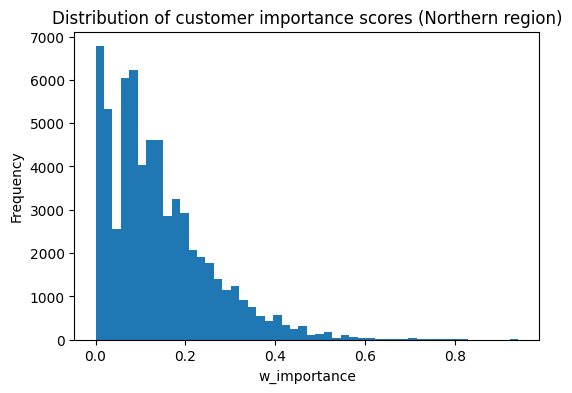

In [12]:
plt.figure(figsize=(6, 4))
plt.hist(df["w_importance"], bins=50)
plt.xlabel("w_importance")
plt.ylabel("Frequency")
plt.title("Distribution of customer importance scores (Northern region)")
plt.show()

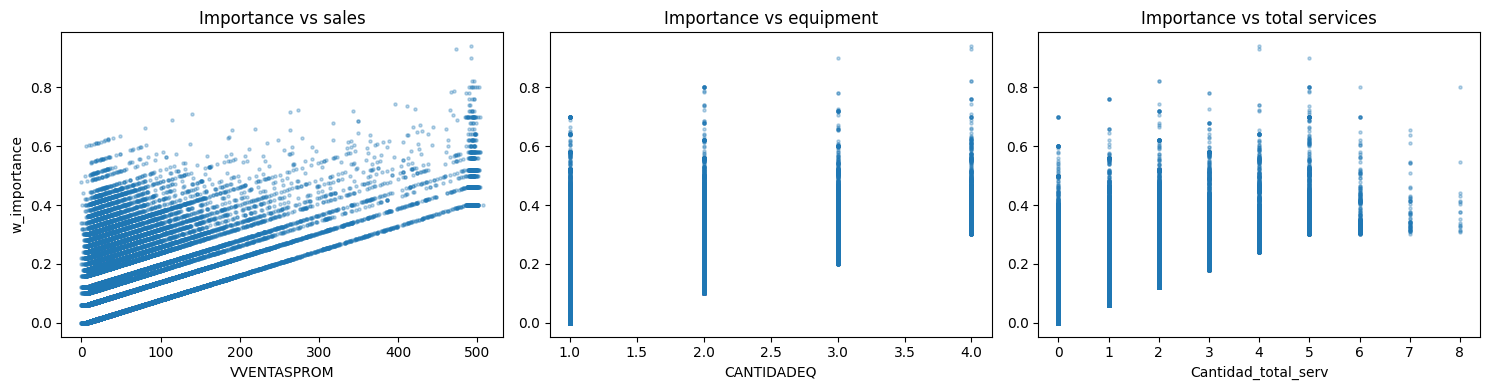

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(df["VVENTASPROM"], df["w_importance"], s=5, alpha=0.3)
axes[0].set_xlabel("VVENTASPROM")
axes[0].set_ylabel("w_importance")
axes[0].set_title("Importance vs sales")

axes[1].scatter(df["CANTIDADEQ"], df["w_importance"], s=5, alpha=0.3)
axes[1].set_xlabel("CANTIDADEQ")
axes[1].set_title("Importance vs equipment")

axes[2].scatter(df["Cantidad_total_serv"], df["w_importance"], s=5, alpha=0.3)
axes[2].set_xlabel("Cantidad_total_serv")
axes[2].set_title("Importance vs total services")

fig.tight_layout()
plt.show()

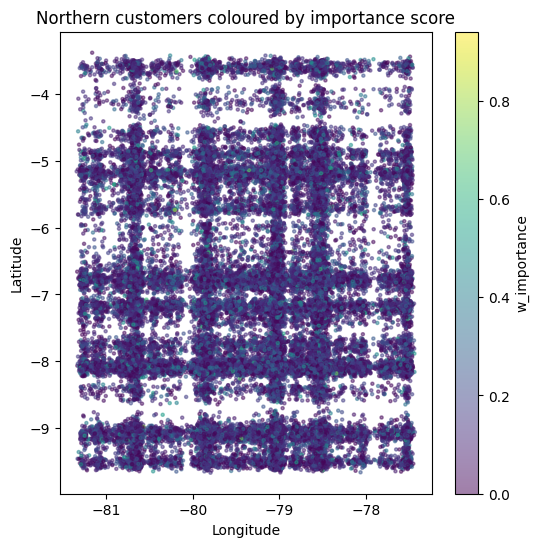

In [14]:
plt.figure(figsize=(6, 6))
sc = plt.scatter(
    df["LNGTUD"],
    df["LATTUD"],
    c=df["w_importance"],
    s=5,
    alpha=0.5,
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Northern customers coloured by importance score")
cbar = plt.colorbar(sc)
cbar.set_label("w_importance")
plt.show()


In [15]:
OUTPUT_PATH = DATA_DIR / "customers_synthetic_north_with_weights.csv"
df.to_csv(OUTPUT_PATH, index=False)
OUTPUT_PATH

WindowsPath('../data/customers_synthetic_north_with_weights.csv')

## Summary

- The three normalised drivers behave quite differently:

  - `sales_norm` is very skewed to the right: most customers show low or
    moderate sales, and only a small group reaches the highest values. This
    fits the idea that a few outlets move most of the volume.

  - `equip_norm` appears in a few vertical bands because `CANTIDADEQ` is an
    integer variable (1, 2, 3, 4 units, etc.). When this is normalised, those
    integers become a small set of distinct levels instead of a smooth curve.

  - `services_norm` also forms steps rather than a smooth shape, since the
    number of services per customer is usually a small integer (0, 1, 2, …).

- The importance score `w_importance` is also skewed to the right: many
  customers end up with a low weight, fewer customers have medium values,
  and only a small group reaches high scores. Esto refleja bien la idea de
  que solo una parte de la red es realmente crítica.

- The scatter plots of `w_importance` against each driver show a clear
  positive relationship with sales, equipment and total services. The
  “striped” patterns come from the fact that several of these variables
  are integer-based, but the overall ranking of customers by importance
  sigue siendo coherente.

- On the map of the Northern region, important customers are spread across
  the territory. No se concentran en un solo punto, pero sí se observan
  zonas más densas donde se combinan mayor número de clientes y mayor
  importancia.

In summary, the weighting scheme produces a reasonable picture of the
network: many low-impact outlets, fewer medium-impact ones, and a small
set of high-impact locations that will be especially relevant for hub
placement in the next notebook.
